In [19]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.style.use("dark_background")

In [20]:
import os
import joblib

# Notebook is inside `notebooks/`
PROJECT_ROOT = os.path.abspath("..")

print("Using project root:", PROJECT_ROOT)

MODEL_DIR = os.path.join(PROJECT_ROOT, "models")

model_path = os.path.join(MODEL_DIR, "tire_degradation_model.pkl")
encoder_path = os.path.join(MODEL_DIR, "compound_encoder.pkl")

if not os.path.exists(model_path):
    raise FileNotFoundError(
        f"Model not found at {model_path}. "
        "Run 02_tire_degradation_model.ipynb first."
    )

if not os.path.exists(encoder_path):
    raise FileNotFoundError(
        f"Encoder not found at {encoder_path}. "
        "Run 02_tire_degradation_model.ipynb first."
    )

model = joblib.load(model_path)
compound_encoder = joblib.load(encoder_path)

print("Model loaded from:", model_path)
print("Encoder loaded from:", encoder_path)

Using project root: /Users/kushagragautam/F1 Strategy Simulator
Model loaded from: /Users/kushagragautam/F1 Strategy Simulator/models/tire_degradation_model.pkl
Encoder loaded from: /Users/kushagragautam/F1 Strategy Simulator/models/compound_encoder.pkl


In [21]:
def load_clean_laps():
    for root, _, files in os.walk("."):
        if "clean_laps.csv" in files:
            return pd.read_csv(os.path.join(root, "clean_laps.csv"))
    raise FileNotFoundError("clean_laps.csv not found.")

laps = load_clean_laps()
laps["LapTimeSeconds"] = pd.to_timedelta(laps["LapTime"]).dt.total_seconds()

laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 01:05:19.554000,VER,1,0 days 00:01:33.433000,2.0,1.0,NaN,NaN,0 days 00:00:29.616000,0 days 00:00:38,0 days 00:00:25.817000,0 days 01:04:15.751000,0 days 01:04:53.751000,0 days 01:05:19.568000,290.0,255.0,244.0,291.0,True,MEDIUM,2.0,True,Red Bull Racing,0 days 01:03:46.121000,2023-07-09 14:04:47.157,1,2.0,False,NaN,False,True,93.433
1,0 days 01:06:52.284000,VER,1,0 days 00:01:32.730000,3.0,1.0,NaN,NaN,0 days 00:00:29.380000,0 days 00:00:37.690000,0 days 00:00:25.660000,0 days 01:05:48.948000,0 days 01:06:26.638000,0 days 01:06:52.298000,311.0,259.0,245.0,318.0,True,MEDIUM,3.0,True,Red Bull Racing,0 days 01:05:19.554000,2023-07-09 14:06:20.590,1,2.0,False,NaN,False,True,92.730
2,0 days 01:08:25.064000,VER,1,0 days 00:01:32.780000,4.0,1.0,NaN,NaN,0 days 00:00:29.407000,0 days 00:00:37.650000,0 days 00:00:25.723000,0 days 01:07:21.705000,0 days 01:07:59.355000,0 days 01:08:25.078000,313.0,259.0,245.0,316.0,False,MEDIUM,4.0,True,Red Bull Racing,0 days 01:06:52.284000,2023-07-09 14:07:53.320,1,2.0,False,NaN,False,True,92.780
3,0 days 01:09:57.646000,VER,1,0 days 00:01:32.582000,5.0,1.0,NaN,NaN,0 days 00:00:29.338000,0 days 00:00:37.403000,0 days 00:00:25.841000,0 days 01:08:54.416000,0 days 01:09:31.819000,0 days 01:09:57.660000,320.0,254.0,244.0,288.0,True,MEDIUM,5.0,True,Red Bull Racing,0 days 01:08:25.064000,2023-07-09 14:09:26.100,1,1.0,False,NaN,False,True,92.582
4,0 days 01:11:30.673000,VER,1,0 days 00:01:33.027000,6.0,1.0,NaN,NaN,0 days 00:00:29.667000,0 days 00:00:37.543000,0 days 00:00:25.817000,0 days 01:10:27.327000,0 days 01:11:04.870000,0 days 01:11:30.687000,290.0,255.0,245.0,285.0,False,MEDIUM,6.0,True,Red Bull Racing,0 days 01:09:57.646000,2023-07-09 14:10:58.682,1,1.0,False,NaN,False,True,93.027


In [22]:
# =========================
# SAFETY CAR CONFIGURATION
# =========================

SC_PROBABILITY = 0.05      # 5% chance per lap
SC_MIN_LAPS = 3
SC_MAX_LAPS = 6

GREEN_PIT_LOSS = 22.0     # seconds
SC_PIT_LOSS = 10.0        # seconds under Safety Car

SC_LAP_MULTIPLIER = 1.30  # lap times are slower under SC

In [23]:
DRIVER = "VER"

TOTAL_LAPS = int(laps["LapNumber"].max())

print("Total race laps:", TOTAL_LAPS)

Total race laps: 52


In [24]:
example_strategy = [
    {"compound": "SOFT", "length": 15},
    {"compound": "MEDIUM", "length": 25},
    {"compound": "HARD", "length": 20}
]

In [33]:
def simulate_strategy(strategy, sc_periods):
    race_time = 0.0
    lap_pointer = 1
    lap_times = []

    for stint_idx, stint in enumerate(strategy):
        compound = stint["compound"]
        stint_length = int(stint["length"])
        compound_encoded = compound_encoder.transform([compound])[0]

        tire_age = 0

        for _ in range(stint_length):
            if lap_pointer > TOTAL_LAPS:
                break

            tire_age += 1
            under_sc = is_safety_car_lap(lap_pointer, sc_periods)

            X = pd.DataFrame({
                "TireAge": [tire_age],
                "LapNumber": [lap_pointer],
                "CompoundEncoded": [compound_encoded]
            })

            lap_time = model.predict(X)[0]

            if under_sc:
                lap_time *= SC_LAP_MULTIPLIER

            lap_times.append(lap_time)
            race_time += lap_time
            lap_pointer += 1

        # Pit stop
        if stint_idx < len(strategy) - 1:
            pit_loss = SC_PIT_LOSS if is_safety_car_lap(lap_pointer, sc_periods) else GREEN_PIT_LOSS
            race_time += pit_loss

    return race_time, lap_times

In [26]:
strategy_1 = [
    {"compound": "SOFT", "length": 18},
    {"compound": "HARD", "length": TOTAL_LAPS - 18}
]

strategy_2 = [
    {"compound": "SOFT", "length": 15},
    {"compound": "MEDIUM", "length": 20},
    {"compound": "HARD", "length": TOTAL_LAPS - 35}
]

strategy_3 = [
    {"compound": "MEDIUM", "length": 25},
    {"compound": "HARD", "length": TOTAL_LAPS - 25}
]

strategies = {
    "Aggressive 1-Stop": strategy_1,
    "Balanced 2-Stop": strategy_2,
    "Conservative": strategy_3
}

In [34]:
np.random.seed(42)  # reproducibility

sc_periods = generate_safety_car_periods(TOTAL_LAPS)
print("Safety Car periods:", sc_periods)

results = {}

for name, strat in strategies.items():
    total_time, lap_times = simulate_strategy(strat, sc_periods)
    results[name] = {
        "total_time": total_time,
        "lap_times": lap_times
    }
    print(f"{name}: {total_time:.2f} s")

Safety Car periods: [(11, 14), (17, 22), (37, 41), (44, 46)]
Aggressive 1-Stop: 5358.36 s
Balanced 2-Stop: 5376.86 s
Conservative: 5363.02 s


In [28]:
comparison = (
    pd.DataFrame({
        "Strategy": results.keys(),
        "TotalTimeSeconds": [v["total_time"] for v in results.values()]
    })
    .sort_values("TotalTimeSeconds")
)

comparison

,Strategy,TotalTimeSeconds
2,Conservative,4860.264870
0,Aggressive 1-Stop,4867.362530
1,Balanced 2-Stop,4876.241377


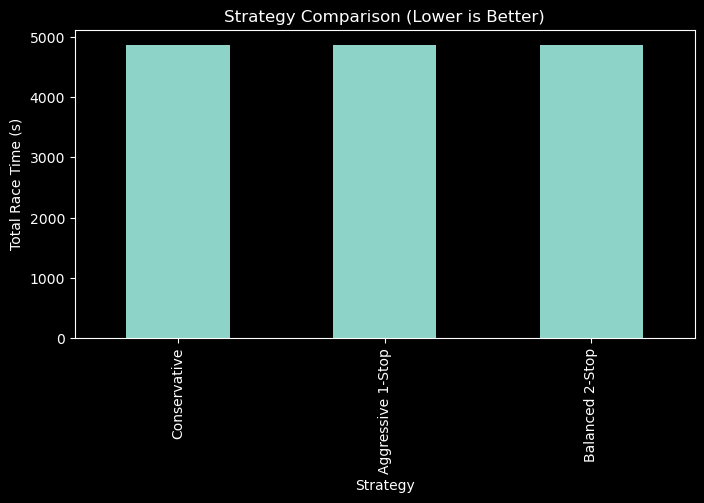

In [30]:
comparison.plot(
    x="Strategy",
    y="TotalTimeSeconds",
    kind="bar",
    figsize=(8,4),
    legend=False,
    title="Strategy Comparison (Lower is Better)"
)

plt.ylabel("Total Race Time (s)")
plt.show()

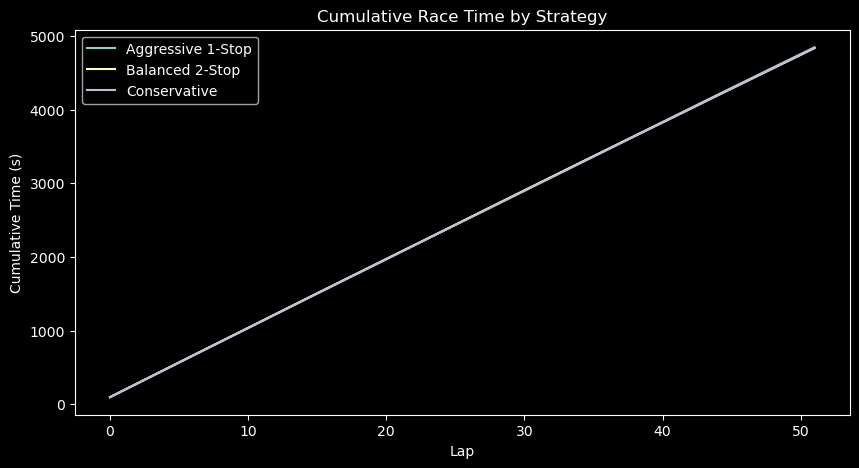

In [29]:
plt.figure(figsize=(10,5))

for name, res in results.items():
    plt.plot(
        np.cumsum(res["lap_times"]),
        label=name
    )

plt.xlabel("Lap")
plt.ylabel("Cumulative Time (s)")
plt.title("Cumulative Race Time by Strategy")
plt.legend()
plt.show()

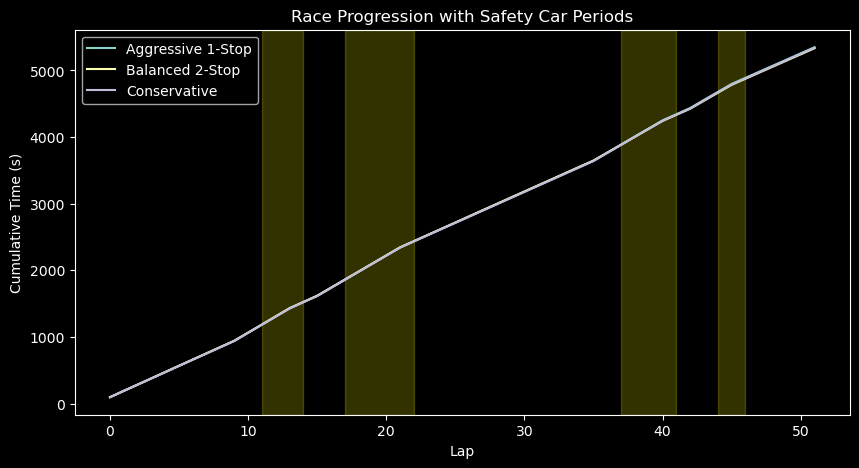

In [35]:
plt.figure(figsize=(10,5))

for name, res in results.items():
    plt.plot(np.cumsum(res["lap_times"]), label=name)

# Highlight Safety Car periods
for start, end in sc_periods:
    plt.axvspan(start, end, color="yellow", alpha=0.2)

plt.xlabel("Lap")
plt.ylabel("Cumulative Time (s)")
plt.title("Race Progression with Safety Car Periods")
plt.legend()
plt.show()

In [31]:
best = comparison.iloc[0]

print("🏁 Recommended Strategy")
print("----------------------")
print("Strategy:", best["Strategy"])
print(f"Predicted Total Time: {best['TotalTimeSeconds']:.2f} s")

🏁 Recommended Strategy
----------------------
Strategy: Conservative
Predicted Total Time: 4860.26 s


In [32]:
def generate_safety_car_periods(total_laps):
    """
    Randomly generate safety car periods across the race.
    Returns list of (start_lap, end_lap).
    """
    sc_periods = []
    lap = 1

    while lap <= total_laps:
        if np.random.rand() < SC_PROBABILITY:
            duration = np.random.randint(SC_MIN_LAPS, SC_MAX_LAPS + 1)
            sc_periods.append((lap, min(lap + duration - 1, total_laps)))
            lap += duration
        else:
            lap += 1

    return sc_periods


def is_safety_car_lap(lap, sc_periods):
    return any(start <= lap <= end for start, end in sc_periods)

In [18]:
output = comparison.copy()
output["DeltaToBest"] = output["TotalTimeSeconds"] - output["TotalTimeSeconds"].min()

os.makedirs("../outputs", exist_ok=True)
output.to_csv("../outputs/strategy_results.csv", index=False)

print("Saved results to outputs/strategy_results.csv")

Saved results to outputs/strategy_results.csv


In [36]:
def generate_strategies(total_laps):
    strategies = []

    # 1-stop strategies
    for pit_lap in range(10, total_laps - 10, 3):
        strategies.append([
            {"compound": "SOFT", "length": pit_lap},
            {"compound": "HARD", "length": total_laps - pit_lap}
        ])
        strategies.append([
            {"compound": "MEDIUM", "length": pit_lap},
            {"compound": "HARD", "length": total_laps - pit_lap}
        ])

    # 2-stop strategies
    for first_pit in range(8, total_laps - 20, 4):
        for second_pit in range(first_pit + 8, total_laps - 8, 4):
            strategies.append([
                {"compound": "SOFT", "length": first_pit},
                {"compound": "MEDIUM", "length": second_pit - first_pit},
                {"compound": "HARD", "length": total_laps - second_pit}
            ])

    return strategies

In [37]:
def evaluate_strategies(strategies, sc_periods):
    results = []

    for idx, strategy in enumerate(strategies):
        total_time, lap_times = simulate_strategy(strategy, sc_periods)
        results.append({
            "strategy_id": idx,
            "strategy": strategy,
            "total_time": total_time,
            "lap_times": lap_times
        })

    return pd.DataFrame(results)

In [38]:
np.random.seed(42)

sc_periods = generate_safety_car_periods(TOTAL_LAPS)
print("Safety Car periods:", sc_periods)

candidate_strategies = generate_strategies(TOTAL_LAPS)
print(f"Generated {len(candidate_strategies)} strategies")

optimizer_results = evaluate_strategies(candidate_strategies, sc_periods)

Safety Car periods: [(11, 14), (17, 22), (37, 41), (44, 46)]
Generated 49 strategies


In [39]:
optimizer_results = optimizer_results.sort_values("total_time").reset_index(drop=True)

best_strategy = optimizer_results.iloc[0]
second_best = optimizer_results.iloc[1]

print("🏁 BEST STRATEGY FOUND")
print("----------------------")
print("Strategy:", best_strategy["strategy"])
print(f"Total Time: {best_strategy['total_time']:.2f} s")

print("\nMargin to P2:", 
      f"{second_best['total_time'] - best_strategy['total_time']:.2f} s")

🏁 BEST STRATEGY FOUND
----------------------
Strategy: [{'compound': 'MEDIUM', 'length': 37}, {'compound': 'HARD', 'length': 15}]
Total Time: 5332.28 s

Margin to P2: 1.10 s


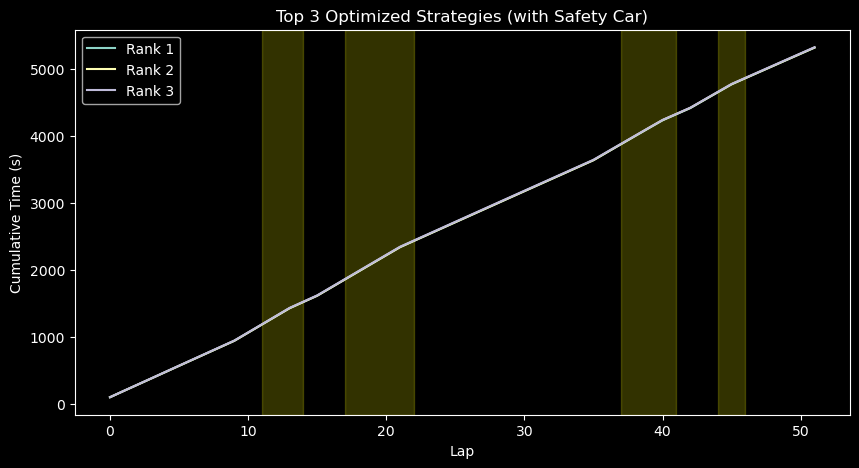

In [40]:
plt.figure(figsize=(10,5))

for i in range(3):
    lap_times = optimizer_results.iloc[i]["lap_times"]
    plt.plot(np.cumsum(lap_times), label=f"Rank {i+1}")

for start, end in sc_periods:
    plt.axvspan(start, end, color="yellow", alpha=0.2)

plt.xlabel("Lap")
plt.ylabel("Cumulative Time (s)")
plt.title("Top 3 Optimized Strategies (with Safety Car)")
plt.legend()
plt.show()

In [41]:
os.makedirs(os.path.join(PROJECT_ROOT, "outputs"), exist_ok=True)

optimizer_results[[
    "strategy_id", "total_time"
]].to_csv(
    os.path.join(PROJECT_ROOT, "outputs", "optimized_strategy_results.csv"),
    index=False
)

print("Saved optimized_strategy_results.csv")

Saved optimized_strategy_results.csv
